# More node interpolation

In [ ]:
import mne
import numpy as np
import pandas as pd
import scipy.io
from scipy.interpolate import NearestNDInterpolator

In [ ]:
import plotly
import plotly.graph_objects as go

## Read in data

In [ ]:
raw = mne.io.read_raw_eeglab("data/927/fixica.set")

In [ ]:
ten_five_montage = mne.channels.make_standard_montage("standard_1005")

In [ ]:
standard_coord = []
for key, value in ten_five_montage.get_positions()["ch_pos"].items():
    standard_coord.append(value.tolist())
standard_coord = np.array(standard_coord)

In [ ]:
# get the coordinate for each nodes and save them in an array
node_list = []
for channel in raw.get_montage().ch_names:
    node_list.append(ten_five_montage.get_positions()["ch_pos"][channel].tolist())
node_coord = np.array(node_list)

In [ ]:
node_list_name = []
for channel in raw.get_montage().ch_names:
    node_list_name.append(
        [
            channel,
            ten_five_montage.get_positions()["ch_pos"][channel][0],
            ten_five_montage.get_positions()["ch_pos"][channel][1],
            ten_five_montage.get_positions()["ch_pos"][channel][2],
        ]
    )
node_df = pd.DataFrame(node_list_name, columns=["channel", "X", "Y", "Z"])

In [ ]:
x = np.array(standard_coord)[:, 0]
y = np.array(standard_coord)[:, 1]
z = np.array(standard_coord)[:, 2]

In [ ]:
df = raw.to_data_frame()

## One time stamp

In [ ]:
eeg = df[df["time"] == 0].loc[:, raw.ch_names].mean().values

In [ ]:
inter = NearestNDInterpolator(node_coord, eeg)

In [ ]:
figu = go.Figure(
    data=[
        go.Mesh3d(
            x=np.array(standard_coord)[:, 0],
            y=np.array(standard_coord)[:, 1],
            z=np.array(standard_coord)[:, 2],
            colorscale="RdBu",
            intensity=inter(np.array(list(zip(x, y, z)))),
            intensitymode="vertex",
            alphahull=1,
            opacity=1,
        )
    ]
)

figu.show()

## Animated - color not normalized

In [ ]:
df.iloc[100:110,:]["time"]

In [ ]:
def interpolated_time_notnor(x, y, z, k):
    now = df[df["time"] == k]
    eeg = now.iloc[:, 1:].mean().values
    interpolate_model = NearestNDInterpolator(node_coord, eeg)
    interpolated_eeg = interpolate_model(np.array(list(zip(x, y, z))))
    return interpolated_eeg

In [ ]:
fig = go.Figure(
    frames=[
        go.Frame(
            data=go.Mesh3d(
                x=np.array(standard_coord)[:, 0],
                y=np.array(standard_coord)[:, 1],
                z=np.array(standard_coord)[:, 2],
                colorscale="Bluered",
                colorbar_title="EEG MicroVolt",
                cmin=-50,
                cmax=50,
                intensity=interpolated_time_notnor(x, y, z, k),
                intensitymode="vertex",
                alphahull=1,
                opacity=1,
            ),
            name=str(
                k
            ),  # you need to name the frame for the animation to behave properly
        )
        for k in df.iloc[100:110,:]["time"]
    ]
)

# Add data to be displayed before animation starts
fig.add_trace(
    go.Mesh3d(
        x=np.array(standard_coord)[:, 0],
        y=np.array(standard_coord)[:, 1],
        z=np.array(standard_coord)[:, 2],
        colorscale="Bluered",
        colorbar_title="EEG Voltage",
        cmin=-50,
        cmax=50,
        intensity=interpolated_time_notnor(x, y, z, 0),
        intensitymode="vertex",
        alphahull=1,
        opacity=1,
    )
)
fig.add_scatter3d(
    connectgaps=True,
    x=node_df["X"],
    y=node_df["Y"],
    z=node_df["Z"],
    text=node_df["channel"],
    mode="markers+text",
    marker={"size": 5, "color": "black"},
    textposition="top left",
    textfont=dict(family="sans serif", size=18, color="White"),
)


def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear", "redraw": False},
    }


sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "currentvalue":{"prefix": "Time stamp : "},
        "steps": [
            {
                "args": [[f.name], frame_args(0)],
                "label": f.name,
                "method": "animate",
            }
            for k, f in enumerate(fig.frames)
        ],
    }
]


fig.update_layout(
    title="EEG Interpolated 3D Graph",
    width=1000,
    height=600,
    scene=dict(
        zaxis=dict(
            range=[
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).min(),
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).max(),
            ],
            autorange=False,
        ),
        aspectratio=dict(x=1.5, y=1.5, z=1),
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, frame_args(0)],
                    "label": "&#9654;",  # play symbol
                    "method": "animate",
                },
                {
                    "args": [[None], frame_args(0)],
                    "label": "&#9724;",  # pause symbol
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 1, "t": 1},
            "type": "buttons",
            "x": 0.1,
            "y": 0,
        }
    ],
    sliders=sliders,
)

## Animated - normalized color

In [ ]:
nb_frames = df[df["time"] > 1557250].head(15)

In [ ]:
def interpolated_time(x, y, z, k):
    now = df[df["time"] == k]
    eeg = now.iloc[:, 1:].mean().values
    interpolate_model = NearestNDInterpolator(node_coord, eeg)
    interpolated_eeg = interpolate_model(np.array(list(zip(x, y, z))))
    return interpolated_eeg

In [ ]:
fig = go.Figure(
    frames=[
        go.Frame(
            data=go.Mesh3d(
                x=np.array(standard_coord)[:, 0],
                y=np.array(standard_coord)[:, 1],
                z=np.array(standard_coord)[:, 2],
                colorscale="Bluered",
                colorbar_title="EEG Voltage",
                cmin=-50,
                cmax=50,
                intensity=interpolated_time(x, y, z, k),
                intensitymode="vertex",
                alphahull=1,
                opacity=1,
            ),
            name=str(
                k
            ),  # you need to name the frame for the animation to behave properly
        )
        for k in nb_frames
    ]
)

# Add data to be displayed before animation starts
fig.add_trace(
    go.Mesh3d(
        x=np.array(standard_coord)[:, 0],
        y=np.array(standard_coord)[:, 1],
        z=np.array(standard_coord)[:, 2],
        colorscale="Bluered",
        colorbar_title="EEG Voltage",
        cmin=-50,
        cmax=50,
        intensity=interpolated_time(x, y, z, 0),
        intensitymode="vertex",
        alphahull=1,
        opacity=1,
    )
)
fig.add_scatter3d(
    connectgaps=True,
    x=node_df["X"],
    y=node_df["Y"],
    z=node_df["Z"],
    text=node_df["channel"],
    mode="markers+text",
    marker={"size": 5, "color": "black"},
    textposition="top left",
    textfont=dict(family="sans serif", size=18, color="White"),
)


def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear", "redraw": False},
    }


sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "args": [[f.name], frame_args(0)],
                "label": str(k),
                "method": "animate",
            }
            for k, f in enumerate(fig.frames)
        ],
    }
]


fig.update_layout(
    title="EEG Interpolated 3D Graph",
    width=1000,
    height=600,
    scene=dict(
        zaxis=dict(
            range=[
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).min(),
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).max(),
            ],
            autorange=False,
        ),
        aspectratio=dict(x=1.5, y=1.5, z=1),
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, frame_args(0)],
                    "label": "&#9654;",  # play symbol
                    "method": "animate",
                },
                {
                    "args": [[None], frame_args(0)],
                    "label": "&#9724;",  # pause symbol
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 1, "t": 1},
            "type": "buttons",
            "x": 0.1,
            "y": 0,
        }
    ],
    sliders=sliders,
)

### 3D animated scatter plot using plotly

In [ ]:
plot_df = raw.to_data_frame()
col_names = plot_df.columns.tolist()[1:]
df = plot_df.melt(
    id_vars="time", value_vars=col_names, var_name="channels", value_name="signal"
)
channel_dict = ten_five_montage.get_positions()["ch_pos"]
plot_df3 = df[df["time"] <= 50]

In [ ]:
plot_df4 = plot_df3.copy()
loca_listx = []
loca_listy = []
loca_listz = []
for index, row in plot_df4.iterrows():
    loca_listx.append(channel_dict[row["channels"]][0])
    loca_listy.append(channel_dict[row["channels"]][1])
    loca_listz.append(channel_dict[row["channels"]][2])
plot_df4["chan_locax"] = loca_listx
plot_df4["chan_locay"] = loca_listy
plot_df4["chan_locaz"] = loca_listz

In [ ]:
fig_scatter = px.scatter_3d(
    plot_df4,
    x="chan_locax",
    y="chan_locay",
    z="chan_locaz",
    color="signal",
    animation_frame="time",
    hover_name="channels",
    text="channels",
    color_continuous_scale="RdYlGn_r",
)

fig_scatter.add_mesh3d(
    x=np.array(standard_coord)[:, 0],
    y=np.array(standard_coord)[:, 1],
    z=np.array(standard_coord)[:, 2],
    alphahull=1,
    opacity=0.4,
    color="cyan",
)

fig_scatter.show()

In [ ]:
import scipy.ndimage

sigma = [6, 6]
zSmooth = scipy.ndimage.filters.gaussian_filter(Z, sigma)

### Script

In [18]:
"""Module for generating and animating the topographic map in a 3D head shape
"""

# import libraries
import mne
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import NearestNDInterpolator
import gif

# define the frame arguments for the animated plot
def frame_args(duration):
    """Return the frame arguments of the animated plot

    Args:
        duration (int): The number of time stamps for the animated plot

    Returns:
        dict: A dictionary of frame arguments
    """
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear", "redraw": False},
    }


def get_standard_coord():
    """Generate an array of cartesian coordinates of the standard node locations ("standard_1005")

    Returns:
        array: A numpy array of cartesian coordinates of the standard node locations ("standard_1005")
    """
    # get the dictionary of standard montage "standard_1005"
    montage = mne.channels.make_standard_montage("standard_1005")
    standard_coord_list = []
    # get the cartesian coordinates from the standard montage dictionary
    for key, value in montage.get_positions()["ch_pos"].items():
        standard_coord_list.append(value.tolist())
    # save the cartesian coordinates in a numpy array
    standard_coord_array = np.array(standard_coord_list)
    return montage, standard_coord_array


def interpolated_time(df, channel_names, node_coord, x, y, z, t):
    """The function to animate the 3D plot

    Args:
        df (dataframe): A dataframe that contains the EEG signal of each electrodes for each time stamps
        channel_names (list): A list of channel names
        node_coord (array): A numpy array of (x, y, z) coordinates of all nodes
        x (array): A numpy array of X coordinates of all nodes for interpolation
        y (array): A numpy array of Y coordinates of all nodes for interpolation
        z (array): A numpy array of Z coordinates of all nodes for interpolation
        t (int): The time stampe we want to interpolate EEG voltages for

    Returns:
        array: A numpy array of interpolated EEG voltages
    """
    # get the EEG data for a specific time stamp
    now = df[df["time"] == t]
    # slice the dataframe to only include EEG signals of each electrodes
    eeg = now.loc[:, channel_names].mean().values
    # build the interpolation model using NearestNDInterpolator
    interpolate_model = NearestNDInterpolator(node_coord, eeg)
    return interpolate_model(np.array(list(zip(x, y, z))))


def get_eeg_node(raw, standard_montage_list):
    """Get the electrode location from the raw data

    Args:
        raw (dataframe): The raw dataframe
        standard_montage_list (array): The numpy array which contains the cartesian coordinate of standard node location

    Returns:
        array: The electrode location from the raw data
    """
    node_list = []
    for channel in raw.get_montage().ch_names:
        node_list.append(
            standard_montage_list.get_positions()["ch_pos"][channel].tolist()
        )
    node_coord = np.array(node_list)
    return node_coord


def get_node_dataframe(raw, montage):
    """Get the electrode name and electrode location from the raw data and save it in a dataframe

    Args:
        raw (dataframe): The raw dataframe
        montage (array): The numpy array which contains the cartesian coordinate of standard node location

    Returns:
        dataframe: A dataframe which contains the electrode name and electrode location from the raw data
    """
    node_list_name = []
    for channel in raw.get_montage().ch_names:
        node_list_name.append(
            [
                channel,
                montage.get_positions()["ch_pos"][channel][0],  # x value
                montage.get_positions()["ch_pos"][channel][1],  # y value
                montage.get_positions()["ch_pos"][channel][2],  # z value
            ]
        )
    node_df = pd.DataFrame(node_list_name, columns=["channel", "X", "Y", "Z"])
    return node_df
    

def animate_3d_head(epoch, plot_title="", color_title="EEG MicroVolt", color_min = -50, color_max = 50, colormap="Bluered"):
    """Plot an animated topographic map in a 3D head shape

    Args:
        epoch (epoch): An epoched file for the EEGLab data
        plot_title (str, optionl): The title of the plot. Defaults to "".
        color_title (str,  optional): The title of the color bar. Defaults to "EEG MicroVolt".
        color_min (int, optional): The minimum EEG voltage value to be shown on the color bar. Defaults to -50.
        color_max (int, optional): The maximum EEG voltage value to be shown on the color bar. Defaults to 50.
        colormap (str, optional): The colour scheme to use. Defaults to Bluered.

    Returns:
        figure: An animated topographic map in a 3D head shape
    """

    # find out the channel names
    channel_names = epoch.ch_names

    # change the raw epoched data to a dataframe
    df = epoch.to_data_frame().groupby("time").mean().reset_index()

    # get the standard montage coordinates
    standard_montage, standard_coord = get_standard_coord()
    x = np.array(standard_coord)[:, 0]
    y = np.array(standard_coord)[:, 1]
    z = np.array(standard_coord)[:, 2]

    # get the coordinated of the electrodes in the raw data
    node_coord = get_eeg_node(epoch, standard_montage)
    node_df = get_node_dataframe(epoch, standard_montage)

    # generate the animated plot
    fig = go.Figure(
        frames=[
            go.Frame(
                data=go.Mesh3d(
                    x=np.array(standard_coord)[:, 0],
                    y=np.array(standard_coord)[:, 1],
                    z=np.array(standard_coord)[:, 2],
                    colorscale=colormap,
                    colorbar_title=color_title,
                    cmin=color_min,
                    cmax=color_max,
                    intensity=interpolated_time(
                        df, channel_names, node_coord, x, y, z, k
                    ),
                    intensitymode="vertex",
                    alphahull=1,
                    opacity=1,
                )
                ,
                name=str(
                    k
                ),  # you need to name the frame for the animation to behave properly
            )
            for k in df["time"]
        ]
    )

    # add data to be displayed before animation starts
    time0 = df.loc[0, "time"]
    fig.add_trace(
        go.Mesh3d(
            x=np.array(standard_coord)[:, 0],
            y=np.array(standard_coord)[:, 1],
            z=np.array(standard_coord)[:, 2],
            colorscale=colormap,
            colorbar_title=color_title,
            cmin=color_min,
            cmax=color_max,
            intensity=interpolated_time(df, channel_names, node_coord, x, y, z, time0),
            intensitymode="vertex",
            alphahull=1,
            opacity=1,
        )
    )

    # add the 3D scatter plot for the electrodes of the raw data
    fig.add_scatter3d(
        connectgaps=True,
        x=node_df["X"],
        y=node_df["Y"],
        z=node_df["Z"],
        text=node_df["channel"],
        mode="markers+text",
        marker={"size": 5, "color": "black"},
        textposition="top center",
        textfont=dict(family="sans serif", size=18),
    )
    

    # set up slider for the animated plot
    sliders = [
        {
            "pad": {"b": 0, "t": 0},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "currentvalue":{"prefix": "Time stamp : ", "visible": True, "xanchor":"center"},
            "steps": [
                {
                    "args": [[f.name], frame_args(0)],
                    "label": f.name,
                    "method": "animate",
                }
                for k, f in enumerate(fig.frames)
            ],
            'transition': {'duration': 0, 'easing': 'linear'},
        }
    ]

    fig.update_layout(
        title=plot_title,
        width=1000,
        height=600,
        scene=dict(
            aspectratio=dict(x=1.5, y=1.5, z=1),
        ),
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, frame_args(0)],
                        "label": "Play",  # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "Pause",  # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 1, "t": 1},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
        sliders=sliders,
        transition=dict(duration=0, easing="linear")
    )
    return fig

# generate the 3D topographic map for a single time stamp
def topo_3d_map(epoch, time_stamp, view_angle=camera, plot_title="", color_title="EEG MicroVolt", color_min = -50, color_max = 50, colormap="Bluered"):
    """Plot a topographic map in a 3D head shape for a single time stamp

    Args:
        epoch (epoch): An epoched file for the EEGLab data
        time_stamp (int): The time stamp that is of interest
        plot_title (str, optionl): The title of the plot. Defaults to "".
        color_title (str,  optional): The title of the color bar. Defaults to "EEG MicroVolt".
        color_min (int, optional): The minimum EEG voltage value to be shown on the color bar. Defaults to -50.
        color_max (int, optional): The maximum EEG voltage value to be shown on the color bar. Defaults to 50.
        colormap (str, optional): The colour scheme to use. Defaults to Bluered.

    Returns:
        figure: A topographic map in a 3D head shape
    """
    # find out the channel names
    channel_names = epoch.ch_names

    # change the raw epoched data to a dataframe
    df = epoch.to_data_frame().groupby("time").mean().reset_index()
    df = df[df["time"] == time_stamp]

    # get the standard montage coordinates
    standard_montage, standard_coord = get_standard_coord()
    x = np.array(standard_coord)[:, 0]
    y = np.array(standard_coord)[:, 1]
    z = np.array(standard_coord)[:, 2]

    # get the coordinated of the electrodes in the raw data
    node_coord = get_eeg_node(epoch, standard_montage)
    node_df = get_node_dataframe(epoch, standard_montage)
    
    fig = go.Figure(
                data=go.Mesh3d(
                    x=np.array(standard_coord)[:, 0],
                    y=np.array(standard_coord)[:, 1],
                    z=np.array(standard_coord)[:, 2],
                    colorscale=colormap,
                    colorbar_title=color_title,
                    cmin=color_min,
                    cmax=color_max,
                    intensity=interpolated_time(
                        df, channel_names, node_coord, x, y, z, time_stamp
                    ),
                    intensitymode="vertex",
                    alphahull=1,
                    opacity=1,
                )
    )
    
    fig.add_scatter3d(
        connectgaps=True,
        x=node_df["X"],
        y=node_df["Y"],
        z=node_df["Z"],
        text=node_df["channel"],
        mode="markers+text",
        marker={"size": 5, "color": "black"},
        textposition="top center",
        textfont=dict(family="sans serif", size=18),
    )
    
    fig.update_layout(
        title=plot_title,
        width=1000,
        height=600,
        scene=dict(
            aspectratio=dict(x=1.5, y=1.5, z=1),
        ),
        scene_camera=view_angle,
    )
    
    return fig

@gif.frame
def topo3dhead_plot(epoch, i):
    fig = topo_3d_map(epoch, i, plot_title = f"Time stamp: {i}")
    return fig

def save_gif(epoch, starting, ending, gifname, duration):
    """Save the animated plot as gif file

    Args:
        starting (int): The starting time of the animated plot.
        ending (int): The ending time of the animated plot.
        gifname (str): The file name.
        duration (int): The duration (milliseconds) between each frame
    """
    frames = []
    for i in range(starting, ending, 1):
        frame = topo3dhead_plot(epoch, i)
        frames.append(frame)
    gif.save(frames, f"{gifname}.gif", duration=duration)

In [2]:
from simpl_eeg import eeg_objects

In [15]:
raw = eeg_objects.Epochs("927", tmin=0, tmax=0)

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data_exploration\data\927\fixica.fdt
Not setting metadata


c:\users\yiki\documents\ubc\mds\homework\capstone\simpl_eeg_capstone\simpl_eeg\eeg_objects.py:22: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  self.raw = mne.io.read_raw_eeglab("data/"+experiment+"/fixica.set")


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 1 original time points ...
0 bad epochs dropped


In [12]:
raw.set_nth_epoch(0)

In [13]:
epoch = raw.get_nth_epoch()

In [ ]:
animate_3d_head(epoch)

In [29]:
camera = dict(
    eye=dict(x=0., y=0., z=2.5),
    
)
camera1 = dict(
    eye=dict(x=2, y=2, z=0.1)
)
camera2 = dict(
    eye=dict(x=-2, y=2, z=0.1)
)
camera3 = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
camera4 = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

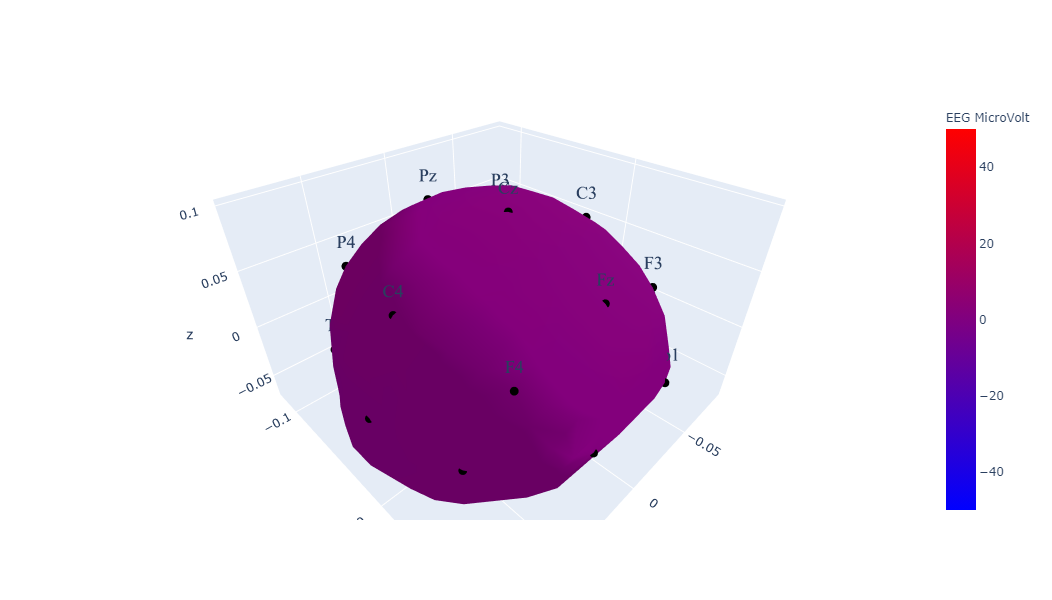

In [30]:
topo_3d_map(epoch, 0, camera3)